In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# 入力ファイルを読み込む
file1 = "IshidaLab_research_project/input_csv_files/binary_protein_data_split_apo_base.csv"  # 1つ目のファイル
file2 = "IshidaLab_research_project/dataset_preprocess/output_csv_files/phase_07/ver_3/max_pocket_rmsd_results1.csv"  # 2つ目のファイル

# CSVデータの読み込み
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

In [19]:
df1_filtered = df1
df2_filtered = df2.loc[df2.groupby(['apo_name', 'apo_chain'])['max_pocket_rmsd'].idxmax()]
#df2_filtered = df2[df2['pocket_id'] == 1]

# 'apo_name', 'apo_chain' が一致する行を1つにまとめる
merged_df = pd.merge(
    df1_filtered[['apo_name', 'apo_chain', 'max_pocket_rmsd']],
    df2_filtered[['apo_name', 'apo_chain', 'max_pocket_rmsd']],
    on=['apo_name', 'apo_chain'],
    suffixes=('_file1', '_file2')  # 列名に接尾辞を追加
)

print(merged_df)

     apo_name apo_chain  max_pocket_rmsd_file1  max_pocket_rmsd_file2
0        1NNA         A               6.857561               6.857561
1        1O73         A               1.954837               1.954837
2        6NTP         A               9.128823              15.964892
3        3SME         A               8.262643                    inf
4        4BJO         A               7.560881                    inf
...       ...       ...                    ...                    ...
3161     4DGV         H               7.451132               0.458482
3162     1BVN         P               1.260954               1.260954
3163     6GFL         A               1.116506               1.116506
3164     3QRX         A               1.736334               1.736334
3165     5YB9         A               0.793545               0.689220

[3166 rows x 4 columns]


In [20]:
import os
output_dir = "IshidaLab_research_project/dataset_preprocess/output_csv_files/phase_09/ver_1"
output_csv = os.path.join(output_dir, "max_pocket_rmsd_results1_no_pocket_id.csv")

# 最大値を抽出し、順番を元のデータの順に保つ
df = df2[df2.groupby(['apo_name', 'apo_chain'])['max_pocket_rmsd'].transform('max') == df2['max_pocket_rmsd']]
df.to_csv(output_csv, index=False)

相関係数: 0.63


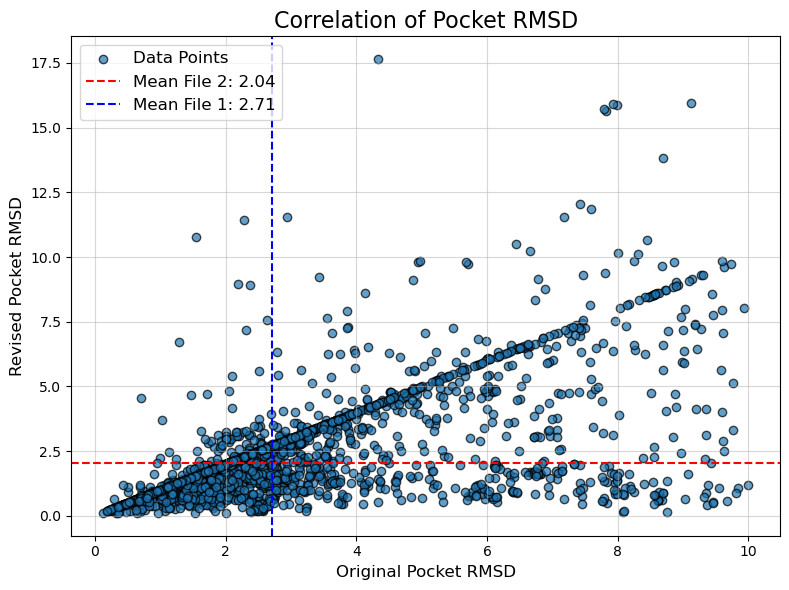

In [21]:
# 列名を明確化
merged_df = merged_df.rename(columns={
    'max_pocket_rmsd_file1': 'file1_pocket_rmsd',
    'max_pocket_rmsd_file2': 'file2_pocket_rmsd'
})
# 欠損値と無限大の値を削除
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['file1_pocket_rmsd', 'file2_pocket_rmsd'])

# pocket_rmsd の相関係数を計算
correlation = merged_df['file1_pocket_rmsd'].corr(merged_df['file2_pocket_rmsd'])

# 相関係数を表示
print(f"相関係数: {correlation:.2f}")

# プロットを作成
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df['file1_pocket_rmsd'], 
    merged_df['file2_pocket_rmsd'], 
    alpha=0.7, edgecolor='k', label='Data Points'
)
plt.title('Correlation of Pocket RMSD', fontsize=16)
plt.xlabel('Original Pocket RMSD', fontsize=12)
plt.ylabel('Revised Pocket RMSD', fontsize=12)
plt.grid(alpha=0.5)

# 平均線を描画
mean_file1 = merged_df['file1_pocket_rmsd'].mean()
mean_file2 = merged_df['file2_pocket_rmsd'].mean()
plt.axhline(y=mean_file2, color='red', linestyle='--', label=f'Mean File 2: {mean_file2:.2f}')
plt.axvline(x=mean_file1, color='blue', linestyle='--', label=f'Mean File 1: {mean_file1:.2f}')
plt.legend(fontsize=12)

plt.tight_layout()

plt.show()

In [26]:
# プロットを保存
output_plot = "pocket_rmsd_correlation.png"
plt.savefig(output_plot, dpi=300)
plt.close()